This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignments/Week6` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

# Problem 6.1. Anomaly Detection.

In this problem, we will use the airline data set to explore the concept of anomaly detection.

In [22]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.utils import check_random_state

from nose.tools import assert_equal, assert_is_instance, assert_false
from numpy.testing import assert_array_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal

We use the following columns:

- Column 1: Month, 1-12
- Column 2: DayofMonth, 1-31
- Column 21: Cancelled, was the flight cancelled?

In [23]:
df = pd.read_csv(
    '/home/data_scientist/data/2001.csv',
    encoding='latin-1',
    usecols=(1, 2, 21)
    )

## The daily number of flights

- Find the total number of flights on each day of 2001. The `get_number_of_flights()` function should return a data frame with a [MultiIndex](http://pandas.pydata.org/pandas-docs/stable/advanced.html) (`Month` and `DayofMonth`). Name the output column `Flights`.

Example output:

```python
>>> flights = get_number_of_flights(df)
>>> print(flights.head())
```
```
                  Flights
Month DayofMonth         
1     1             16081
      2             17612
      3             17573
      4             17570
      5             17576
```

In [24]:
def get_number_of_flights(df):
    '''
    Computes the total number of flights on each day.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame.
    Each day is grouped, and the number of flights is in a column named "Flights".
    '''
    
    cols = ['Month','DayofMonth']
    result = df.groupby(cols).count() #groupby two columns for multi-index
    result.columns = ['Flights']
        
    return result

In [25]:
flights = get_number_of_flights(df)
print(flights.head())

                  Flights
Month DayofMonth         
1     1             16081
      2             17612
      3             17573
      4             17570
      5             17576


In [26]:
assert_is_instance(flights, pd.DataFrame)
assert_is_instance(flights.index, pd.MultiIndex)

assert_equal(len(flights), 365)
assert_equal(flights.index.names, ['Month', 'DayofMonth'])
assert_equal(flights.columns, 'Flights')

assert_array_equal(flights.Flights.values[:5], [16081, 17612, 17573, 17570, 17576])
assert_array_equal(flights.Flights.values[-5:], [14622, 14547, 12821, 13319, 13014])

## Daily cancellations

- Find the total number of cancellations on each day of 2001. The `get_cancellations()` function should return a data frame with a [MultiIndex](http://pandas.pydata.org/pandas-docs/stable/advanced.html) (`Month` and `DayofMonth`). The name of the output column should be `Cancelled`.

Example output:

```python
>>> cancelled = get_cancellations(df)
>>> print(cancelled.head())
```
```
                  Cancelled
Month DayofMonth           
1     1                1190
      2                 706
      3                 575
      4                 474
      5                 877
```

In [27]:
def get_cancellations(df):
    '''
    Computes the total number of cancellations on each day.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame.
    Each day is grouped, and the number of cancellations is in a column named "Cancelled".
    '''
    
    cols = ['Month','DayofMonth']
    group_sums = df.groupby(cols)['Cancelled'].sum()
    result = pd.DataFrame(group_sums)
    
    return result

In [28]:
cancelled = get_cancellations(df)
print(cancelled.head())

                  Cancelled
Month DayofMonth           
1     1                1190
      2                 706
      3                 575
      4                 474
      5                 877


In [29]:
assert_is_instance(cancelled, pd.DataFrame)
assert_is_instance(cancelled.index, pd.MultiIndex)

assert_equal(len(cancelled), 365)
assert_equal(cancelled.index.names, ['Month', 'DayofMonth'])
assert_equal(cancelled.columns, 'Cancelled')

assert_array_equal(cancelled.Cancelled.values[:5], [1190, 706, 575, 474, 877])
assert_array_equal(cancelled.Cancelled.values[-5:], [193, 203, 41, 76, 75])

## Find and visualize outliers

- Find and visualize outliers. For our purposes, we define a data point $x$ to be an outlier if $x > \mu + 3\sigma$ or $x < \mu - 3\sigma$, where $\mu$ and $\sigma$ are mean and standard deviation, respectively. Plot the histogram of **all** data points (inliers pluts outliers) first, and then plot the histogram of **outliers** with a different color.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week6/assignments/images/flights_outliers.png)
![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week6/assignments/images/cancelled_outliers.png)

In [30]:
def plot_outliers(df, column, bins):
    '''
    Finds and visualizes outliers.
    
    Parameters
    ----------
    df: A pandas DataFrame.
    column: A string.
    bins: A numpy array. Histogram bins.
    
    Returns
    -------
    A Matplotlib Axes instance.
    '''
    
    sns.set(style="white", font_scale=1.0)  
    fig, ax = plt.subplots(figsize=(10,6))     
    
    mean = df[column].mean()
    stdev = df[column].std()
    outliers = df[(df[column] < mean-3*stdev) | (df[column] > mean+3*stdev)] #mask for outliers
    
    #plot histograms of outliers and inliers
    ax.hist(df[column], bins=bins, alpha=0.5, color=sns.xkcd_rgb["denim blue"], label = 'Inliers') 
    ax.hist(outliers[column], bins=bins, alpha=1.0, color=sns.xkcd_rgb["orange"], label = 'Outliers')
    
    ax.legend()    
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Days', fontsize=14)   
    
    sns.despine(ax=ax, offset=0, trim=False)    
    
    return ax

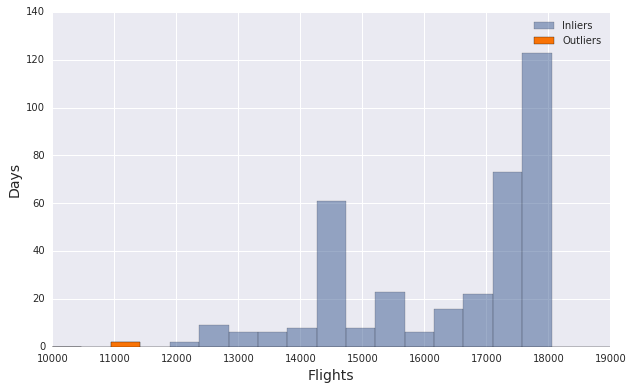

In [31]:
ax_flights = plot_outliers(flights, 'Flights', bins=np.linspace(10000, 19000, 20))

In [32]:
assert_is_instance(ax_flights, mpl.axes.Axes)

# np.linspace(?, ?, 20) produces 19 bars
# 19 * 2 patches for inliers and outliers
patches = ax_flights.patches
assert_equal(len(patches), 38)

bins_a = np.linspace(10000, 19000, 20)

# test first 19 patches (inliers)
freq_i = [0, 0, 2, 0, 2, 9, 6, 6, 8, 61, 8, 23, 6, 16, 22, 73, 123, 0, 0]

for i in range(19):
    assert_almost_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_i[i])

# test next 19 patches (outliers)
freq_o = [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i in range(19):
    assert_almost_equal(patches[i + 19].get_x(), bins_a[i])
    assert_almost_equal(patches[i + 19].get_height(), freq_o[i])

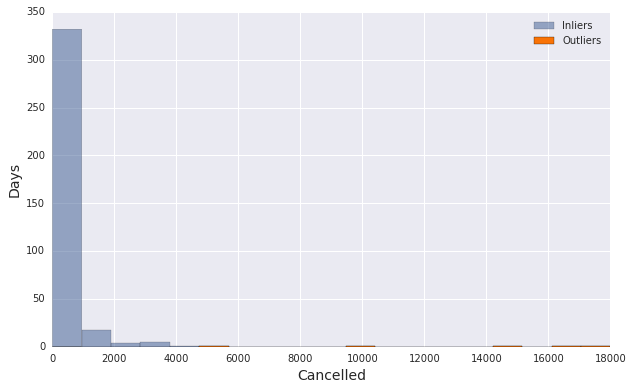

In [33]:
ax_cancelled = plot_outliers(cancelled, 'Cancelled', bins=np.linspace(0, 18000, 20))

In [34]:
assert_is_instance(ax_cancelled, mpl.axes.Axes)

# np.linspace(?, ?, 20) produces 19 bars
# 19 * 2 patches for inliers and outliers
patches = ax_cancelled.patches
assert_equal(len(patches), 38)

bins_a = np.linspace(0, 18000, 20)

# test first 19 patches (inliers)
freq_i = [332, 18, 4, 5, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]

for i in range(19):
    assert_almost_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_i[i])

# test next 19 patches (outliers)
freq_o = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]

for i in range(19):
    assert_almost_equal(patches[i + 19].get_x(), bins_a[i])
    assert_almost_equal(patches[i + 19].get_height(), freq_o[i])

## Two-dimensioanl plot

- Create a scatter plot of bivariate distribution.

Create a scatter plot of **inliers** first, and then create a scatter plot of **outliers**. We define a data point $(x, y)$ to be an outlier if *any* of the following conditions are true:

 - $x > \mu + 3\sigma$,
 - $x < \mu - 3\sigma$,
 - $y > \mu + 3\sigma$, or
 - $y < \mu - 3\sigma$.

where $\mu$ and $\sigma$ are mean and standard deviation, respectively.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week6/assignments/images/two_dim_outliers.png)

In [35]:
def plot_2d(df_x, df_y, col_x, col_y):
    '''
    Creates a two-diemnsional plot of bivariate distribution.
    
    Parameters
    ----------
    df_x: A pandas.DataFrame.
    df_y: A pandas.DataFrame.
    col_x: A string. The column in "df_x" that will be used as the x variable.
    col_y: A string. The column in "df_y" that will be used as the x variable.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    #make local copies
    df_x = df_x.copy()
    df_y = df_y.copy()
        
    sns.set(style="white", font_scale=1.0) 
    fig, ax = plt.subplots(figsize=(10,6))     
    
    #calculate mean and spread for both df_x and df_y
    mean_x = df_x[col_x].mean()
    mean_y = df_y[col_y].mean()    
    stdev_x = df_x[col_x].std()
    stdev_y = df_y[col_y].std()
    
    #find outliers (each have x and y coordinates)
    outliers_x1 = df_x[(df_y[col_y] < mean_y-3*stdev_y) | (df_y[col_y] > mean_y+3*stdev_y)]
    outliers_y1 = df_y[(df_y[col_y] < mean_y-3*stdev_y) | (df_y[col_y] > mean_y+3*stdev_y)]    
    
    outliers_x2 = df_x[(df_x[col_x] < mean_x-3*stdev_x) | (df_x[col_x] > mean_x+3*stdev_x)]
    outliers_y2 = df_y[(df_x[col_x] < mean_x-3*stdev_x) | (df_x[col_x] > mean_x+3*stdev_x)]  
    
    #combine outliers into one dataframe
    outliers_x = pd.concat([outliers_x1, outliers_x2])
    outliers_y = pd.concat([outliers_y1, outliers_y2])

    #drop outliers from the inliers dataframe
    df_x.drop(outliers_x.index, inplace = True)
    df_y.drop(outliers_y.index, inplace = True)
    
    #plot scatter plots
    ax.scatter(df_x, df_y, marker = 'o', color=sns.xkcd_rgb["denim blue"], label = 'Inliers')
    ax.scatter(outliers_x, outliers_y, marker = '*', color=sns.xkcd_rgb["orange"], label = 'Outliers')
    
    ax.set_xlabel(col_x, fontsize=14)
    ax.set_ylabel(col_y, fontsize=14) 
    ax.legend()
    
    sns.despine(ax=ax, offset=0, trim=False)    
    
    return ax

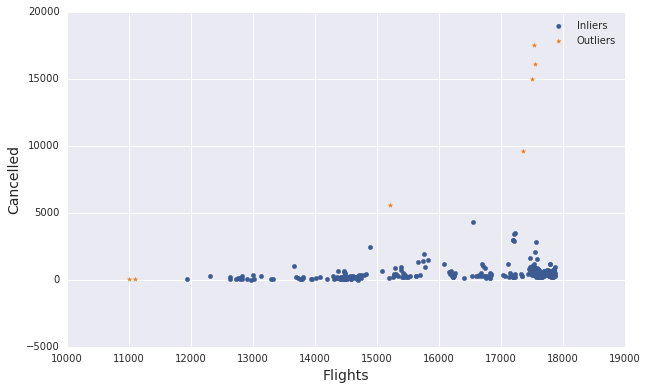

In [36]:
ax_2d = plot_2d(flights, cancelled, 'Flights', 'Cancelled')

In [37]:
assert_is_instance(ax_2d, mpl.axes.Axes)

x_i, y_i = ax_2d.collections[0].get_offsets().T # inliers
x_o, y_o = ax_2d.collections[1].get_offsets().T # outliers

idx_o = [253, 254, 255, 256, 257, 325, 326]
idx_i = [i for i in range(365) if i not in idx_o]

assert_array_equal(x_i, flights.ix[idx_i, 'Flights'])
assert_array_equal(y_i, cancelled.ix[idx_i, 'Cancelled'])

assert_array_equal(x_o, flights.ix[idx_o, 'Flights'])
assert_array_equal(y_o, cancelled.ix[idx_o, 'Cancelled'])

c_i = ax_2d.collections[0].get_facecolor()[0]
c_o = ax_2d.collections[1].get_facecolor()[0]
assert_false((c_i == c_o).all(), msg='Use different colors.')

## Cluster Analysis

- Scale the data set by using `StandardScaler()`, and then apply the DBSCAN algorithm on our data set to find noise points.

Use `eps=0.5` (default) and `min_samples=5` (default). Use default values for all paramters.

In [38]:
def dbscan_outliers(df):
    '''
    Find outliers (noise points) using DBSCAN.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A tuple of (a sklearn.DBSCAN instance, a pandas.DataFrame)
    '''
    
    #scale data
    scaled = StandardScaler().fit_transform(df)
    
    
    db = DBSCAN()
    labels = pd.DataFrame(data=db.fit_predict(scaled), index=df.index) #
    
    #outliers when they are classed as -1
    outliers = df[labels[0] == -1]
    
    return db, outliers

DBSCAN finds two outliers, which are the same three-sigma outliers we found eariler.

```python
>>> db_flights, db_flights_outliers = dbscan_outliers(flights)
>>> print(db_flights_outliers)
```
```
                  Flights
Month DayofMonth         
11    22            11001
      23            11098
```

These were of course Thanksgiving Day of 2001 and the day after Thanksgiving.

In [39]:
db_flights, db_flights_outliers = dbscan_outliers(flights)
print(db_flights_outliers)

                  Flights
Month DayofMonth         
11    22            11001
      23            11098


In [40]:
assert_is_instance(db_flights, DBSCAN)
assert_is_instance(db_flights_outliers, pd.DataFrame)
assert_equal(db_flights.eps, 0.5)
assert_equal(db_flights.min_samples, 5)
assert_frame_equal(
    db_flights_outliers,
    pd.DataFrame({'Flights': [11001, 11098]},
        index=pd.MultiIndex.from_product([[11], [22, 23]], names=['Month', 'DayofMonth']))
    )

It is not difficult to guess which days will be outliers when it comes to cancellations.

```python
>>> db_cancelled, db_cancelled_outliers = dbscan_outliers(cancelled)
>>> print(db_cancelled_outliers)
```
```
                  Cancelled
Month DayofMonth           
9     11              14962
      12              17535
      13              16109
      14               9611
      15               5573
```

In [41]:
db_cancelled, db_cancelled_outliers = dbscan_outliers(cancelled)
print(db_cancelled_outliers)

                  Cancelled
Month DayofMonth           
9     11              14962
      12              17535
      13              16109
      14               9611
      15               5573


In [42]:
assert_is_instance(db_cancelled, DBSCAN)
assert_is_instance(db_cancelled_outliers, pd.DataFrame)
assert_equal(db_cancelled.eps, 0.5)
assert_equal(db_cancelled.min_samples, 5)
assert_frame_equal(
    db_cancelled_outliers,
    pd.DataFrame({'Cancelled': [14962, 17535, 16109, 9611, 5573]},
        index=pd.MultiIndex.from_product([[9], [11, 12, 13, 14, 15]], names=['Month', 'DayofMonth']))
    )